In [448]:
import nltk
import json
import time 
from sklearn import preprocessing as pre
import numpy as np

from nltk.corpus import stopwords

tokenizer = nltk.tokenize.RegexpTokenizer(r"\w+")
import pickle
from scipy.sparse import csr_matrix
from Stemmer import Stemmer
lemmatizer = nltk.stem.WordNetLemmatizer()
import random
from sklearn.manifold import TSNE
from matplotlib import pyplot as plt


In [2]:
stem_dict = dict()
lemmatize_dict = dict()


In [3]:
index_path = "/Users/skosgi/Downloads/nlp/"

infile = open("/Users/skosgi/Downloads/nlp/reviews_Electronics_5.json","r")
index_path = "/Users/skosgi/Downloads/nlp/"


In [4]:
def clean(data):
    punctuations = '0123456789'
    
    d = str.maketrans(dict.fromkeys(punctuations," "))
    data = data.translate(d)
    return data
    

In [121]:
def preprocess(token):
    stemmer = Stemmer('english')
    if token in stem_dict:
        token = stem_dict[token]
    else:
        stem_word = stemmer.stemWord(token)
        stem_dict[token] = stem_word
        token = stem_word
    if token in lemmatize_dict:
        token = lemmatize_dict[token]
    else:
        lem_word = lemmatizer.lemmatize(token)
        lemmatize_dict[token] = lem_word
        token = lem_word
    return token

In [515]:
review_count=10000

In [557]:
#code to generate dictionary of words, this also generates Negative sampling table(final_list).
t = time.time()
token_set = set()
count = 0;
stop_words = stopwords.words('english')
infile = open("/Users/skosgi/Downloads/nlp/reviews_Electronics_5.json","r")
freq_map = {}
for line in infile:
    count += 1
    if count == review_count:
        break
    jsondict = json.loads(line)
    review_text = clean(jsondict["reviewText"].lower())
    tokens = tokenizer.tokenize(review_text)
    
    for token in tokens:
        if len(token) <=2:
            continue
        token = preprocess(token)
        token_set.add(token)
        if token in freq_map.keys():
            freq_map[token] = freq_map[token]+1
        else:
            freq_map[token] = 1
token_set = list(token_set)
token_set = [k for k in freq_map.keys() if freq_map[k]>=5]        
print("token_set",len(token_set))

infile.close()
enc_map = {}
for i in range(len(token_set)):
    enc_map[token_set[i]] = i
final_list = []
total_prob=0
table_size = 100000000
for key in token_set:
    k = freq_map[key]
    k = np.power(k,0.75)
    total_prob +=k
for key in token_set:
    k = freq_map[key]
    k = np.power(k,0.75)
    pr_k = table_size*k/total_prob
    for i in range(int(pr_k)):
        final_list.append(key)
        
print(time.time()-t)


token_set 4940
13.150115966796875


In [542]:
pickfile = open("dictionary_mappingsg2","wb")
pickle.dump(enc_map,pickfile)
pickfile.close()

In [519]:
def sigmoid(x):
    return 1/(1+np.exp(-x))

In [520]:

#   Code to generate Samples. It fills 3 arrays.X(input),Y(positive output) and N(Negative samples)
count = 0;
dict_count = len(token_set)
stop_words = stopwords.words('english')
window = 3
infile = open("/Users/skosgi/Downloads/nlp/reviews_Electronics_5.json","r")
t = time.time()
X = []
Y = []
N = []
for line in infile:
    count += 1
    if count == review_count:
        break
    jsondict = json.loads(line)
    review_text = clean(jsondict["reviewText"].lower())
    tokens = tokenizer.tokenize(review_text)
    new_tokens = []
    for token in tokens:
        if len(token)<=2:
            continue
        token = preprocess(token)
        if freq_map[token]<5:
            continue
        new_tokens.append(token)    
    tokens = new_tokens   
    for i in range(len(tokens)):
        y_index = enc_map[tokens[i]]
        x_out = np.zeros((dict_count,))
        x_out[y_index] = 1
        y_context = []
        Neg = []
        j_count = 0
        for j in range(i-window,i+window+1):
            if j!=i and j<len(tokens) and j>=0:
                j_count+=1
                x_temp = np.zeros((dict_count,))
                x_index = enc_map[tokens[j]]
                x_temp[x_index] = 1
                y_context.append(x_index) 
        randnums = random.sample(range(len(final_list)),5)
        for rand in randnums:
            neg_word = final_list[rand]
            neg_index = enc_map[neg_word]
            n_temp = np.zeros((dict_count,))
            n_temp[neg_index]=1
            Neg.append(neg_index)        
        Y.append(y_context)
        X.append(y_index)
        N.append(Neg)    
        if(len(X)%50000==0):
            print("50k samples generated")
infile.close()
print(time.time()-t) 

50k samples generated
50k samples generated
50k samples generated
50k samples generated
50k samples generated
50k samples generated
50k samples generated
50k samples generated
50k samples generated
50k samples generated
50k samples generated
50k samples generated
50k samples generated
50k samples generated
50k samples generated
50k samples generated
50k samples generated
44.13071084022522


In [558]:
print(len(X))

856135


In [398]:
def forwardProp(x,y,W1,W2):
    h = W1[x]
    u = np.dot(W2.T[y],h)
    y_pred = sigmoid(u)
    return h,u,y_pred

In [521]:
def training(alpha,epochs,encoder_length):
    #print(time.time()-t1)
    t = time.time()
    W1 = np.random.uniform(-0.8,0.8,(dict_count,encoder_length))
    W2 = np.random.uniform(-0.8,0.8,(encoder_length,dict_count))
    dw2 = np.zeros(W2.shape)
    dw1 = np.zeros(W1.shape)
    for i in range(epochs):
        loss = 0
        p=0
        for j in range(len(X)):
            if j%100000 ==0:
                print("100k done!")
                #print("t100",time.time()-t)
            p+=1
            t0 = time.time()
            x = X[j]
            #print(x)
            #dw2 = np.zeros(W2.shape)
            dw1[x] = np.zeros(W1.shape[1])
            t1 = time.time()

            #for y in Y[j][0]:
            for y in Y[j]:
                h,u,y_pred = forwardProp(x,y,W1,W2)
                loss += -np.log(y_pred)            
                dw2.T[y] = h*(y_pred-1)
                dw1[x] += W2.T[y]*(y_pred-1)
            t2 = time.time()
            N[j] = [n for n in N[j] if n not in Y[j]]
            for n in N[j]:
                h,u,y_pred = forwardProp(x,n,W1,W2)
                #print("y",y_pred)
                loss += -np.log(1-y_pred)
                dw2.T[n] = h*y_pred
                dw1[x] += W2.T[n]*y_pred
            for y in Y[j]:
                W2.T[y] = W2.T[y]-alpha*dw2.T[y]
            for n in N[j]:
                W2.T[n] = W2.T[n]-alpha*dw2.T[n]
            t4 = time.time()
            W1[x] = W1[x]-alpha*dw1[x]
            
            t3 = time.time()
        print("No. of iterations:{}, loss:{}".format(i,loss))
        print(time.time()-t)
        if i%20==0:
            pickfile = open("skipgram_parameters2","wb")
            pickle.dump(W1,pickfile)
    print(time.time()-t)    

In [522]:
training(0.01,100,100)    

100k done!
100k done!
100k done!
100k done!
100k done!
100k done!
100k done!
100k done!
100k done!
No. of iterations:0, loss:6516530.128770456
200.53109502792358
100k done!
100k done!
100k done!
100k done!
100k done!
100k done!
100k done!
100k done!
100k done!
No. of iterations:1, loss:5814537.697598275
386.7836129665375
100k done!
100k done!
100k done!
100k done!
100k done!
100k done!
100k done!
100k done!
100k done!
No. of iterations:2, loss:5617898.560766266
576.1239397525787
100k done!
100k done!
100k done!
100k done!
100k done!
100k done!
100k done!
100k done!
100k done!
No. of iterations:3, loss:5509288.117348146
763.351655960083
100k done!
100k done!
100k done!
100k done!
100k done!
100k done!
100k done!
100k done!
100k done!
No. of iterations:4, loss:5437458.878578247
950.6432898044586
100k done!
100k done!
100k done!
100k done!
100k done!
100k done!
100k done!
100k done!
100k done!
No. of iterations:5, loss:5384756.52051199
1139.3589189052582
100k done!
100k done!
100k done!
1

100k done!
100k done!
100k done!
100k done!
100k done!
100k done!
100k done!
100k done!
No. of iterations:51, loss:4964514.221583117
9866.208273887634
100k done!
100k done!
100k done!
100k done!
100k done!
100k done!
100k done!
100k done!
100k done!
No. of iterations:52, loss:4962211.623127158
10054.496430158615
100k done!
100k done!
100k done!
100k done!
100k done!
100k done!
100k done!
100k done!
100k done!
No. of iterations:53, loss:4959975.754916333
10243.161245822906
100k done!
100k done!
100k done!
100k done!
100k done!
100k done!
100k done!
100k done!
100k done!
No. of iterations:54, loss:4957803.466369726
10432.199699878693
100k done!
100k done!
100k done!
100k done!
100k done!
100k done!
100k done!
100k done!
100k done!
No. of iterations:55, loss:4955691.802831041
10621.477267026901
100k done!
100k done!
100k done!
100k done!
100k done!
100k done!
100k done!
100k done!
100k done!
No. of iterations:56, loss:4953637.993492473
10812.045915842056
100k done!
100k done!
100k done!
1

In [524]:
def vector(word):
    pickfile = open("skipgram_parameters2","rb")
    w1 = pickle.load(pickfile)
    return w1[enc_map[preprocess(word)]]    

In [527]:
a = vector("camera")
print(a)

[-0.14293598  0.37898354  0.46394955 -0.23686334  0.31166653  0.01384924
  0.14757504  0.2822596   0.38947384 -0.02446139  0.08780087 -0.09145903
 -0.45241306  0.38050427  0.1270326   0.34816611  0.19654143  0.0313007
 -0.30355489  0.1289258   0.11602251  0.12763697  0.08636705 -0.275089
  0.13530559  0.18536333 -0.17535636 -0.26797285  0.34005036 -0.19780731
  0.37205776 -0.01342058 -0.38922718 -0.11636491  0.19380603 -0.2219386
 -0.11486295  0.17637688 -0.11576069 -0.1506918  -0.36205055  0.5418616
  0.00252126 -0.31127348 -0.21496669  0.23703371  0.2658677  -0.12718166
  0.21025002  0.07054467  0.54141329  0.2540037  -0.17323959 -0.28765072
  0.25071124 -0.16504275 -0.04726763  0.1088582  -0.08353822  0.28568607
 -0.28060568  0.10028177 -0.12025568  0.36199659  0.92367953 -0.25173447
  0.23636671  0.21262886 -0.19027988 -0.42581747 -0.14589755 -0.35792239
  0.05878582 -0.03283561  0.04129483  0.02930252  0.05234729 -0.4186416
 -0.02196955 -0.36881438  0.18756035  0.18050571  0.69178

In [528]:
def similar_words(word,count):
    pickfile = open("skipgram_parameters2","rb")
    w1 = pickle.load(pickfile)
    word_vec = w1[enc_map[preprocess(word)]]
    similarity = {}
    for i in range(len(token_set)):
        new_vec = w1[i]
        dot = np.dot(word_vec,new_vec)
        magnitude = np.linalg.norm(new_vec)*np.linalg.norm(word_vec)
        cosine_similarity = dot/magnitude
        similarity[token_set[i]] = cosine_similarity
     
    similarity = sorted(similarity.items(),reverse=True,key = lambda similarity: (similarity[1],similarity[0]))
    k =0
    for wr,score in similarity:
        if k==count:
            break
        print(wr,score)
        k+=1
        

In [552]:
def similar_vectors(word,count):
    pickfile = open("skipgram_parameters2","rb")
    w1 = pickle.load(pickfile)
    word_vec = w1[enc_map[preprocess(word)]]
    similarity = {}
    for i in range(len(token_set)):
        new_vec = w1[i]
        dot = np.dot(word_vec,new_vec)
        magnitude = np.linalg.norm(new_vec)*np.linalg.norm(word_vec)
        cosine_similarity = dot/magnitude
        similarity[token_set[i]] = cosine_similarity
     
    similarity = sorted(similarity.items(),reverse=True,key = lambda similarity: (similarity[1],similarity[0]))
    k =0
    sim_vector = []
    print("------- Similar words for {}-------------".format(word))
    for wr,score in similarity:
        if k==count:
            break
        sim_vector.append(enc_map[wr])    
        print(wr)
        k+=1
    return sim_vector    

In [562]:
print("Similar words for camera on skipgram word2vec model using Negative Sampling:")
similar_words('camera',10)

Similar words for camera on skipgram word2vec model using Negative Sampling:
camera 1.0000000000000002
len 0.6360120718961924
and 0.5990720894993904
this 0.5652517897859117
you 0.545348721619646
use 0.5410933308010849
zoom 0.518922123192067
one 0.5086358622892903
with 0.5077737605433669
canon 0.50069443367631


In [543]:
w1 = load_model()
embedding = TSNE(n_components=2).fit_transform(w1)
print(embedding)

[[-1.1302162   3.53775   ]
 [ 0.18294862 -1.0722537 ]
 [ 2.360141    6.3970227 ]
 ...
 [-7.358746    5.469925  ]
 [-5.97994     4.7740808 ]
 [ 2.0634887  -2.3136    ]]


In [567]:
def load_model():
    pickfile = open("skipgram_parameters2","rb")
    w1 = pickle.load(pickfile)
    wfile = open("dictionary_mappingsg2","rb")
    pickfile.close()
    wfile.close()
    dict_map = pickle.load(wfile)
    return w1,dict_map

In [548]:
def sim_embeddings(word,count):
    sim_vectors = similar_vectors(word,count)
    x = [embedding[i][0] for i in sim_vectors]
    y = [embedding[i][1] for i in sim_vectors]
    return x,y

------- Similar words for music-------------
music
listen
classic
hear
movi
bass
sound
textbook
record
genr
------- Similar words for noise-------------
nois
cancel
ambient
hiss
sound
block
earbud
volum
loud
bose
------- Similar words for seeing-------------
see
say
get
imag
jupit
know
photo
give
sure
find
------- Similar words for good-------------
good
great
well
decent
veri
excel
nice
better
qualiti
like
------- Similar words for review-------------
review
peopl
here
post
read
rave
articl
research
said
sabrent


Text(0.5, 1.0, 'Word vectors using skipgram model')

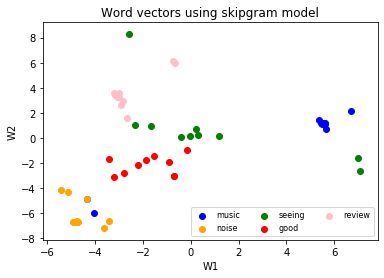

In [563]:
x,y = sim_embeddings("music",10)
x1,y1 = sim_embeddings("noise",10)
x2,y2 = sim_embeddings("seeing",10)
x3,y3 = sim_embeddings("good",10)
x4,y4 = sim_embeddings("review",10)
xy = plt.scatter(x,y,color = "blue")
x1y1 = plt.scatter(x1,y1,color="orange")
x2y2 = plt.scatter(x2,y2,color="green")
x3y3 = plt.scatter(x3,y3,color="red")
x4y4 = plt.scatter(x4,y4,color="pink")


plt.xlabel("W1")
plt.ylabel("W2")
plt.legend((xy, x1y1, x2y2, x3y3, x4y4),
           ('music', 'noise', 'seeing', 'good', 'review'),
           scatterpoints=1,
           loc='lower right',
           ncol=3,
           fontsize=8)
plt.title("Word vectors using skipgram model")